# Object Detection  Cases : Ships Detection

- Main Goals:

We want to identify and detect ships that passed certain area of our location

- Dataset Information:

This dataset contains a vast collection of 26.9k images, which have been carefully annotated for the specific purpose of ship detection. The bounding box annotations are presented in the YOLO format, which allows for accurate and efficient detection of the ships in the images. The dataset has been curated to include images of only one class "ship".

# Importing Libraries

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/67/0e/5fbad3db52fae8f63cc7a55885b1f685d12660a205f1727c5ee7c67726de/ultralytics-8.3.151-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.0 from https://files.pythonhosted.org/packages/a6/10/251f036b4c5d77249f9a119cc89dafe8745dc1ad1f1a5f06b6a3988ca454/ultralytics_thop-2.0.14-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from collections import defaultdict
import random
import zipfile
import glob


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# zip_path = '/content/drive/MyDrive/Aerial-Ship-Image-Datasets/ships-aerial-images.zip'
# extract_to = '/kaggle/input/aerial-ship-dataset'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)


# In kaggle dataset

In [ ]:
extract_to = "/kaggle/input/aerial-ship-dataset"

# Import Datasets

In [ ]:
image_counts = {}
splits = ["train", "test", "valid"]
for split in splits:
    image_dir = os.path.join(extract_to, "ships-aerial-images", split, "images")
    image_counts[split] = len(glob.glob(os.path.join(image_dir, "*")))

print("Image counts per split:", image_counts)


Image counts per split: {'train': 9697, 'test': 1573, 'valid': 2165}


There are roughly ten thousand pictures for teaching the model, a couple of thousand to see how it’s doing while it learns, and about one and a half thousand kept aside for the final scorecard so most of the images help it learn, and the rest help us check that it isn’t just memorising and can truly recognise new ship photos. but anyways, the percentage of the splits is:
1. Training: 72.18 %
2. Validation: 16.11 %
3. Test: 11.71 %

In [ ]:


train_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"
train_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/labels"

test_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/images"
test_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/labels"

val_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/images"
val_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/labels"


# Kaggle trrain test val path

In [ ]:
train_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"
train_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/labels"

test_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/images"
test_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/labels"

val_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/images"
val_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/labels"

# EDA

## EDA For Image

### Sample Visualization Image

for the first step of eda, we're going to randomly select images of ships with their corresponding bounding boxes, to get a gist of the raw data that we're dealing with

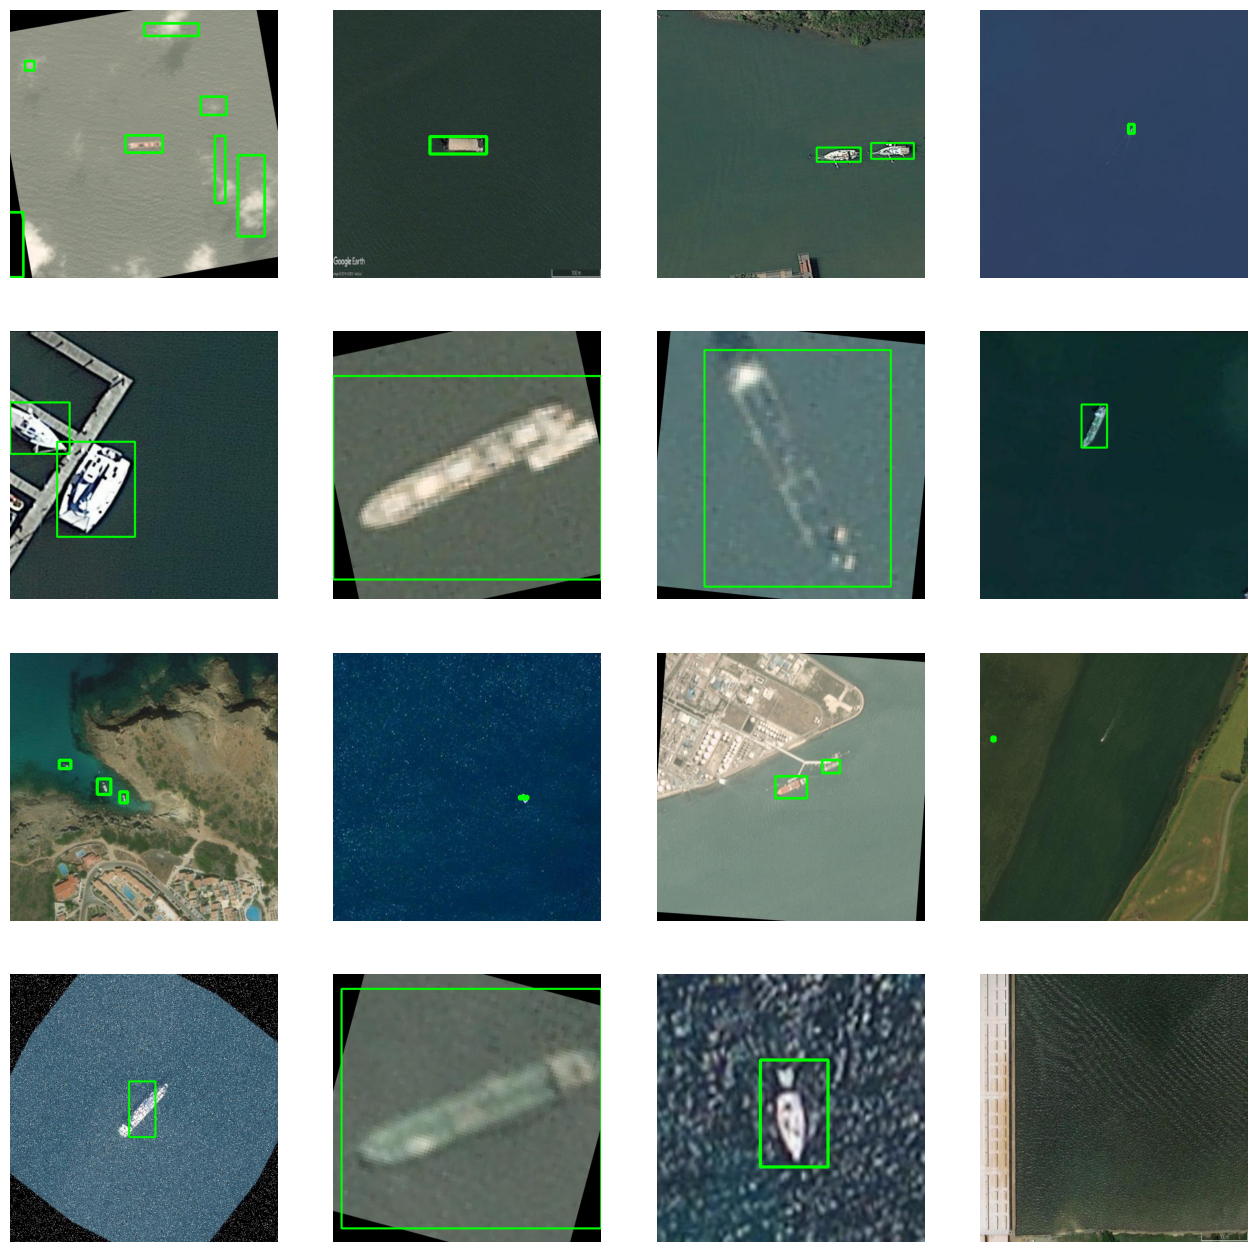

In [ ]:
image_files = os.listdir(train_images)

random_images = random.sample(image_files, 16)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

### Checking Ratio Image

next we're going to check various attributes of our images, including their file type, aspect ratio, resolution

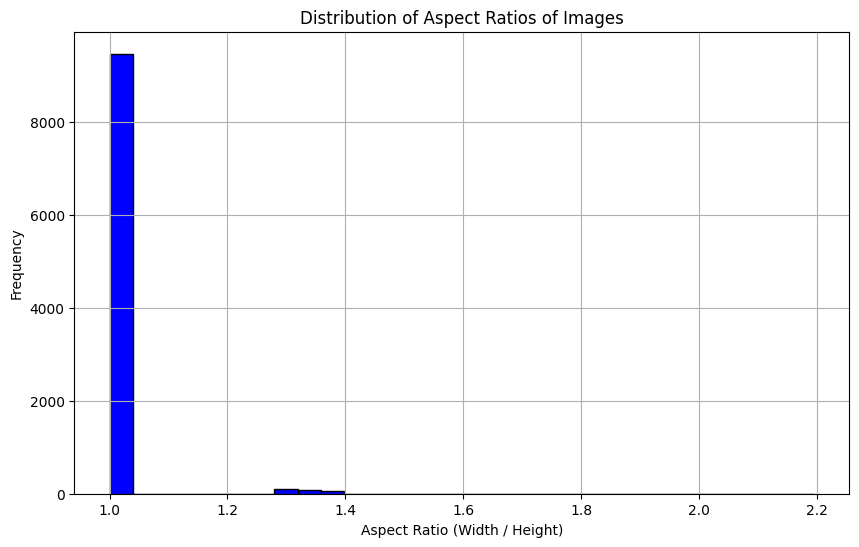

In [ ]:
image_files = os.listdir(train_images)

# List to store the aspect ratios
aspect_ratios = []

# Loop through each image file
for image_file in image_files:
    # Construct the image path
    image_path = os.path.join(train_images, image_file)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Check if image is loaded correctly
    if image is not None:
        # Get the dimensions (height, width, channels) of the image
        height, width, _ = image.shape

        # Calculate the aspect ratio (width / height)
        aspect_ratio = width / height
        aspect_ratios.append(aspect_ratio)

# Plot the distribution of aspect ratios
plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Aspect Ratios of Images')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

as we can see from the plot above, majority of our images are in the desired 1:1 aspect ratio, however there are few that exceed this desired ratio

### Checking resolution (Height & Weight Image)

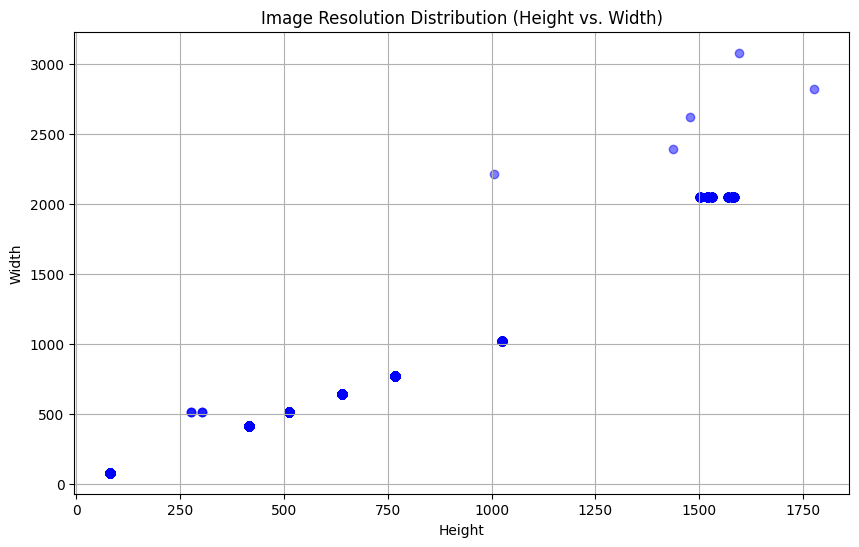

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset directory (replace with the actual path to your dataset)
# dataset_dir = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"
dataset_dir = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"

# List to store the resolutions (height, width)
resolutions = []

# Loop through all images in the dataset directory
for img_file in os.listdir(dataset_dir):
    img_path = os.path.join(dataset_dir, img_file)

    # Read the image in full color (BGR by default)
    img = cv2.imread(img_path)

    # Check if the image is loaded successfully
    if img is not None:
        height, width, _ = img.shape
        resolutions.append((height, width))

# Convert resolutions to a numpy array for easier indexing
resolutions = np.array(resolutions)

# Create a scatter plot for Image Resolution Distribution (Height vs. Width)
plt.figure(figsize=(10, 6))
plt.scatter(resolutions[:, 0], resolutions[:, 1], alpha=0.5, color='blue')
plt.title('Image Resolution Distribution (Height vs. Width)')
plt.xlabel('Height')
plt.ylabel('Width')
plt.grid(True)
plt.show()



despite most of the images being 1:1 aspect ratio, their resoltuions differ. Hence, we will convert the resolutions of all our images to a standardized resoltuion

the non equal aspect ratios can also be seen from the resolution graph above, where there are some data points that width=/height

### Image File Type Checking

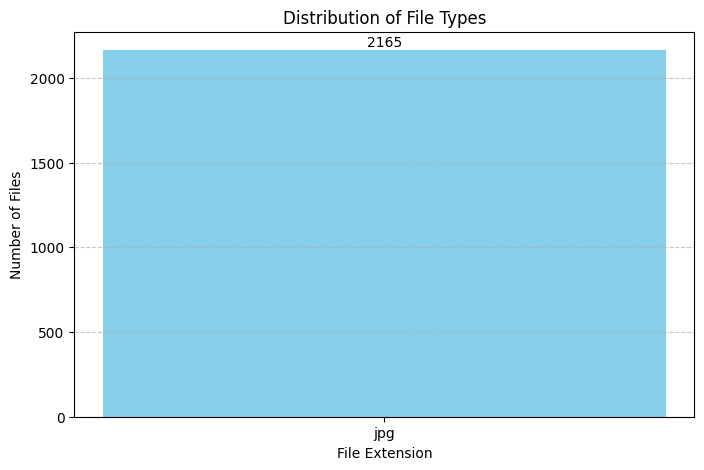

In [ ]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt

def plot_filetype_distribution(folder_path):
    file_types = defaultdict(int)

    for fname in os.listdir(folder_path):
        ext = fname.split('.')[-1].lower()
        file_types[ext] += 1

    # Plot
    labels = list(file_types.keys())
    counts = list(file_types.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xlabel("File Extension")
    plt.ylabel("Number of Files")
    plt.title("Distribution of File Types")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Annotate bar values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}', ha='center', va='bottom')

    plt.show()

plot_filetype_distribution(val_images)



from the plot of file type distributions, all our images are in jpg, which is fine. this means no changing of file type is required. (we checked both train and test images too, all are in jpg:)

### Validating & Looking Which Files Need To Resize

In [ ]:
from PIL import Image
import os

def validate_images(folder_path, valid_extensions={'jpg', 'png'}, min_width=224, min_height=224):
    valid_count = 0
    invalid_count = 0
    resize_needed = 0

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        ext = fname.split('.')[-1].lower()

        # Skip non-image file types
        if ext not in valid_extensions:
            invalid_count += 1
            continue

        try:
            img = Image.open(fpath)
            width, height = img.size

            if width >= min_width and height >= min_height:
                valid_count += 1
            else:
                resize_needed += 1

        except Exception as e:
            print(f"Failed to read {fname}: {e}")
            invalid_count += 1

    print(f":) Valid images: {valid_count}")
    print(f":| Images requiring resize: {resize_needed}")
    print(f":( Invalid files: {invalid_count}")


In [ ]:
print(f'Test results')
validate_images(test_images, min_width=224, min_height=224)
print(f'========================================================')
print(f'Train results')
validate_images(train_images, min_width=224, min_height=224)
print(f'========================================================')
print(f'Val results')
validate_images(val_images, min_width=224, min_height=224)

Test results
:) Valid images: 1506
:| Images requiring resize: 67
:( Invalid files: 0
Train results
:) Valid images: 9235
:| Images requiring resize: 462
:( Invalid files: 0
Val results
:) Valid images: 2034
:| Images requiring resize: 131
:( Invalid files: 0


here we created a simple function to count th enumber of valid images per set, as well as the number of invalid images.


## EDA For Labels

similarly to the images, we're going to conduct eda on the bounding boxes of each image.

for bounding boxes, we're going to check the aspect ratios, resolution and frequency of bounding boxes for each image

### Distribution Of Bounding Box per splits

In [ ]:
# base_dir = "/kaggle/input/aerial-ship-dataset/ships-aerial-images"
base_dir = "/kaggle/input/aerial-ship-dataset/ships-aerial-images"
splits = ["train", "valid", "test"]

records = []
for split in splits:
    label_dir = os.path.join(base_dir, split, "labels")
    for label_file in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(label_file, 'r') as f:
            lines = [l for l in f if l.strip()]
        box_count = len(lines)
        records.append({
            "split": split,
            "boxes_in_image": box_count
        })

df_counts = pd.DataFrame(records)


In [ ]:
df_counts.head(10)


split  boxes_in_image
0  train               1
1  train               0
2  train               9
3  train               1
4  train               1
5  train               1
6  train               1
7  train               2
8  train               1
9  train               1

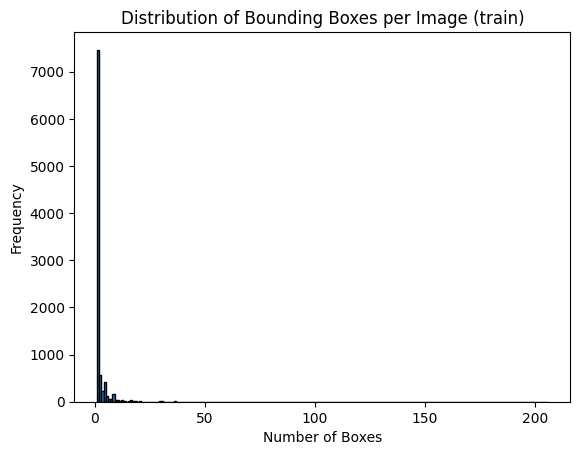

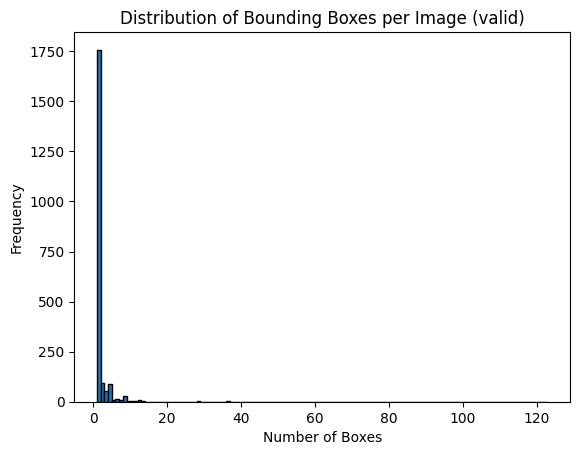

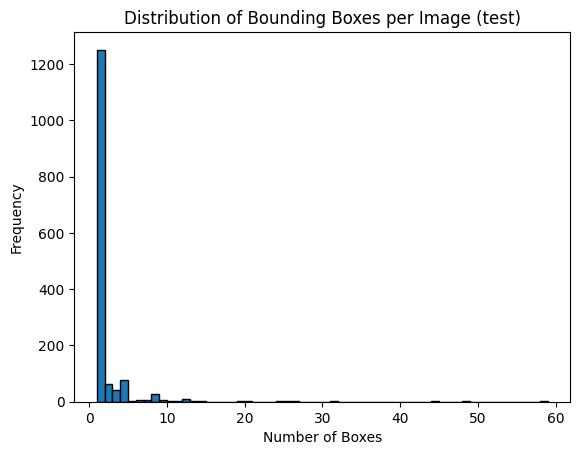

        count      mean       std  min  25%  50%  75%    max
split                                                       
test   1573.0  1.825811  3.339968  0.0  1.0  1.0  1.0   58.0
train  9697.0  2.006394  5.445155  0.0  1.0  1.0  1.0  205.0
valid  2165.0  1.718245  3.879786  0.0  1.0  1.0  1.0  122.0


In [ ]:
for split in splits:
    counts = df_counts[df_counts["split"] == split]["boxes_in_image"]
    plt.figure()
    plt.hist(counts, bins=range(1, counts.max()+2), edgecolor='black')
    plt.title(f"Distribution of Bounding Boxes per Image ({split})")
    plt.xlabel("Number of Boxes")
    plt.ylabel("Frequency")
    plt.show()

summary = df_counts.groupby("split")["boxes_in_image"].describe()
print(summary)


## Bounding Box Distribution Frequency Analysis

From the “Distribution of Bounding Boxes per Image” histograms for each split (train, validation, test), we observe:

1. Most images contain very few boxes
In all splits, the peak frequency is at 1–5 boxes per image. In other words, the majority of images have only one or two ships labeled.
2. There is a long tail of images with many boxes
Although relatively rare, some images have dozens or even hundreds of bounding boxes. This creates a strongly right-skewed distribution: most images are “simple” (few boxes), but a small number are “dense” (many boxes).
3. Possible images with zero boxes (not shown in the label plots)
We plotted only those label files that actually exist, but it’s worth verifying whether any images have no corresponding label file at all (zero boxes). These “all-background” images need special handling.

Preprocessing methods for later

First, we will validate and clean every label file to ensure consistency. Each .txt file will be checked to confirm that its normalized YOLO coordinates lie within the [0, 1] range and that any absolute-pixel annotations (if present) do not exceed the source image’s width and height. We will convert all normalized boxes into absolute-pixel format (xmin, ymin, xmax, ymax) based on each image’s original dimensions. Any image without a corresponding label file (i.e., zero boxes) will be inspected, and we will decide whether to keep it as a pure-background example or remove it entirely so the model only trains on images that contain at least one ship.

Next, we will address the highly skewed “boxes per image” distribution. Images containing an unusually large number of bounding boxes (for example, more than 50) will be treated as outliers: we will either split those images into smaller patches or cap the number of boxes per image to prevent GPU memory blowup and overly large loss values. After handling outliers, every image will be resized (or letterbox-padded) to a fixed input size such as 640×640, and bounding boxes will be scaled accordingly. Finally, we will apply targeted data augmentations—standard flips, rotations, and color jitters for images with only a few boxes, and additional random crops or copy-paste augmentations for dense scenes—so that the model sees a balanced variety of images with varying object counts.





# Distribution Boxplot Bounding Box  

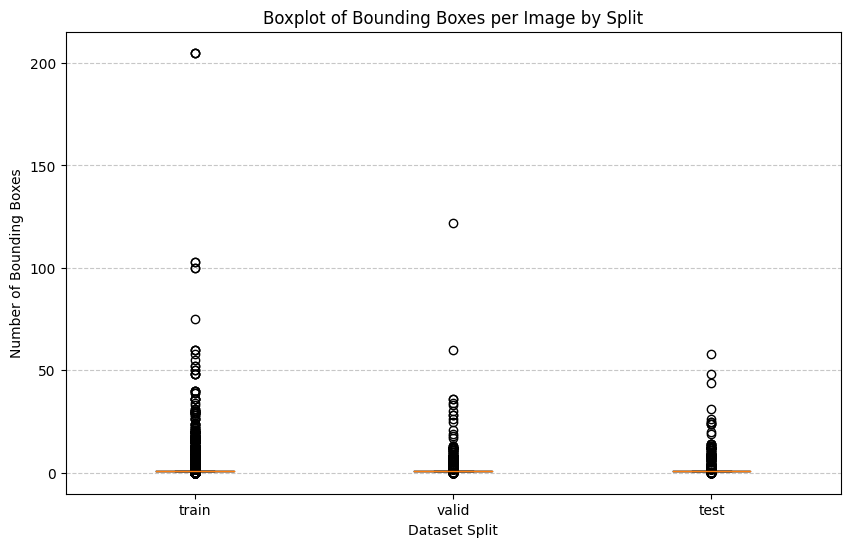

In [ ]:
if not df_counts.empty:
    boxplot_data = [
        df_counts[df_counts["split"] == s]["boxes_in_image"]
        for s in splits
    ]

    plt.figure(figsize=(10, 6))
    plt.boxplot(boxplot_data, labels=splits, showfliers=True)
    plt.title("Boxplot of Bounding Boxes per Image by Split")
    plt.xlabel("Dataset Split")
    plt.ylabel("Number of Bounding Boxes")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# else:
    # boxplot_data = [
    #     df_counts[df_counts["split"] == s]["boxes_in_image"]
    #     for s in splits
    # ]

    # plt.figure(figsize=(10, 6))
    # plt.boxplot(boxplot_data, labels=splits, showfliers=True)
    # plt.title("Boxplot of Bounding Boxes per Image by Split")
    # plt.xlabel("Dataset Split")
    # plt.ylabel("Number of Bounding Boxes")
    # plt.grid(axis="y", linestyle="--", alpha=0.7)
    # plt.show()

Handling The outliers ?

So later in preprocessing, we’ll first inspect each image’s annotation count and normalize the coordinate formats (e.g., convert all boxes to [x_min, y_min, x_max, y_max] relative to the resized image dimensions). Next, for images with extremely high box counts (e.g., >50 annotations), we’ll apply a cap or tiling strategy either clustering densely packed regions into sub-images or sampling a fixed maximum of boxes per crop to avoid memory overload. We’ll also pad or truncate low‐annotation images so that each training batch has a roughly uniform distribution of box counts, ensuring the model sees both “sparse” and “dense” examples. Finally, we’ll apply standard augmentations (random flips, scaling, color jitter) while preserving bounding‐box alignment, and compute class‐balanced weights if some object types appear primarily in high‐density scenes. This way, our network is trained on consistently formatted inputs that represent the full spectrum of object‐counts without being skewed by the rare extreme cases.

### Visualisasi Resolusi (Height & Width Bounding Box)

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# train_images  = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"
# train_labels  = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/labels"
# test_images   = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/images"
# test_labels   = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/labels"
# val_images    = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/images"
# val_labels    = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/labels"

def compute_image_metrics(image_dir, label_dir):
    mean_widths  = []
    mean_heights = []
    mean_areas   = []
    aspect_ratios = []

    for lbl_path in glob.glob(os.path.join(label_dir, "*.txt")):
        basename = os.path.basename(lbl_path).replace(".txt", "")
        img_path = None
        for ext in [".png", ".jpg", ".jpeg", ".bmp"]:
            cand = os.path.join(image_dir, basename + ext)
            if os.path.isfile(cand):
                img_path = cand
                break
        if img_path is None:
            continue

        with Image.open(img_path) as img:
            img_w, img_h = img.size

        widths  = []
        heights = []
        areas   = []
        ars     = []

        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                w_norm = float(parts[3])
                h_norm = float(parts[4])

                bbox_w = w_norm * img_w
                bbox_h = h_norm * img_h
                bbox_area = bbox_w * bbox_h
                ar = bbox_w / bbox_h if bbox_h > 0 else 0

                widths.append(bbox_w)
                heights.append(bbox_h)
                areas.append(bbox_area)
                ars.append(ar)

        if not widths:
            continue

        mean_widths.append(np.mean(widths))
        mean_heights.append(np.mean(heights))
        mean_areas.append(np.mean(areas))
        aspect_ratios.extend(ars)

    return (
        np.array(mean_widths),
        np.array(mean_heights),
        np.array(mean_areas),
        np.array(aspect_ratios),
    )


train_mw, train_mh, train_ma, train_ar = compute_image_metrics(train_images, train_labels)
test_mw,  test_mh,  test_ma,  test_ar  = compute_image_metrics(test_images,  test_labels)
val_mw,   val_mh,   val_ma,   val_ar   = compute_image_metrics(val_images,   val_labels)

metrics = {
    "Train": (train_mw, train_mh, train_ma, train_ar, "tab:blue"),
    "Test":  (test_mw,  test_mh,  test_ma,  test_ar,  "tab:orange"),
    "Valid": (val_mw,   val_mh,   val_ma,   val_ar,   "tab:green"),
}

# Distribution MEAN WIDTH vs. MEAN HEIGHT

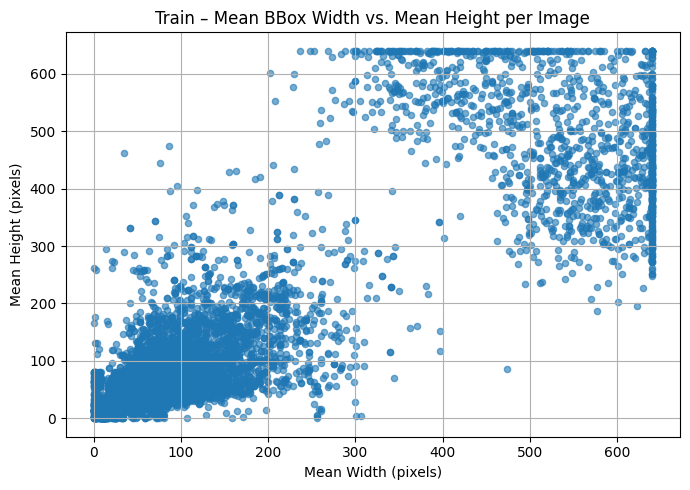

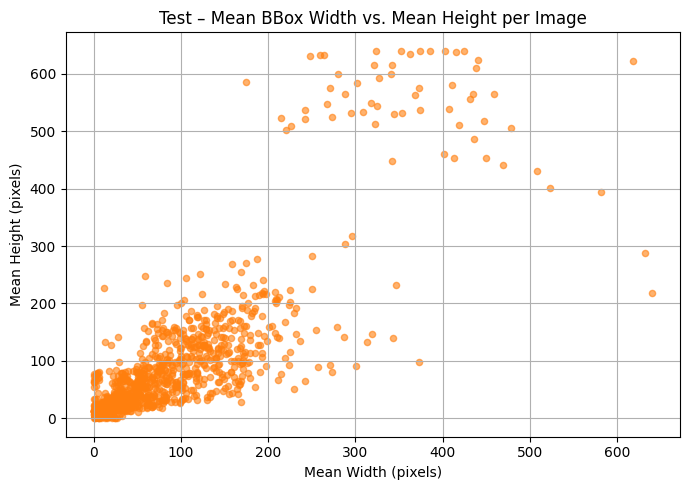

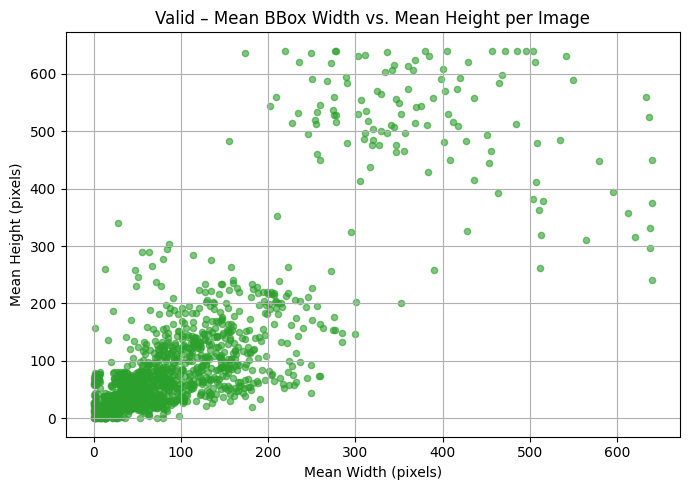

In [ ]:
for split_name, (mw, mh, ma, ar, color) in metrics.items():
    plt.figure(figsize=(7,5))
    plt.scatter(mw, mh, s=20, alpha=0.6, color=color)
    plt.title(f"{split_name} – Mean BBox Width vs. Mean Height per Image")
    plt.xlabel("Mean Width (pixels)")
    plt.ylabel("Mean Height (pixels)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

here we plot the distribution of both width and height of bounding boxes within images. as we can see the width and height varies heavily. indicating the the bounding boxes for each image differs from one another. this could be due to the presenece of different ships, different zooms of the images, etc. Anyways we can see that's theres a lot of bounding box tht has low pixel and thus this could be a threat later for our training and testing model so we gonna drop it later.

# Distribution Mean Bounding Box

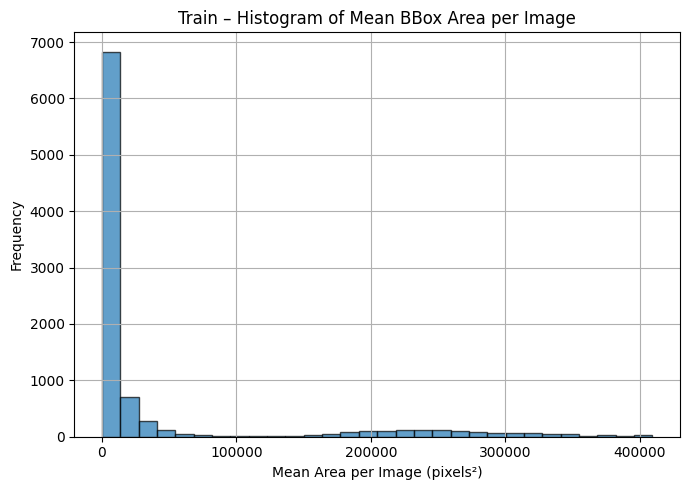

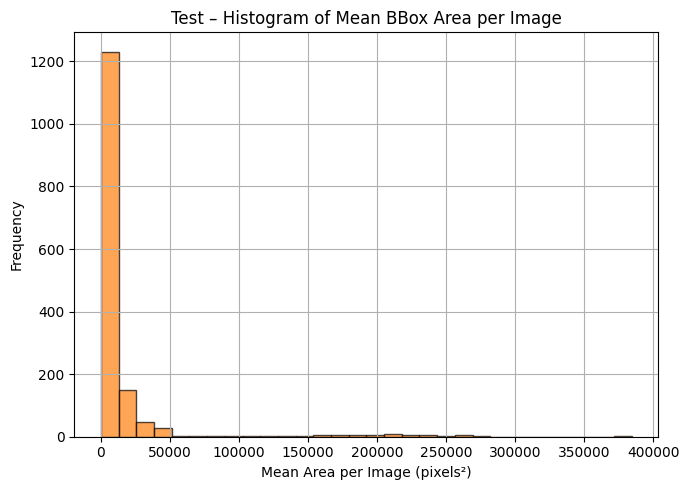

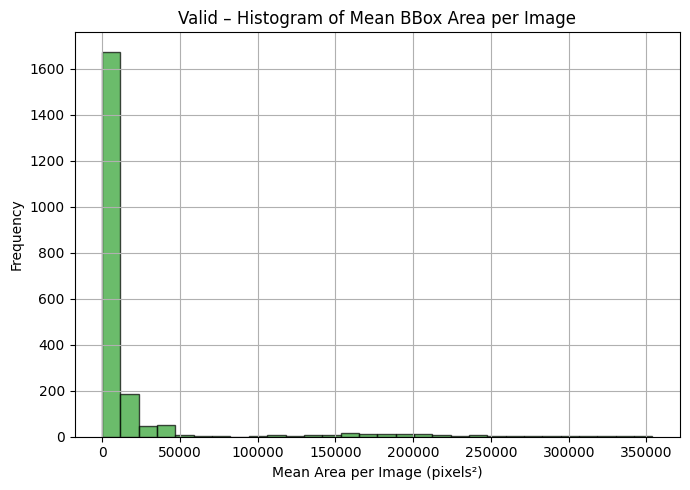

In [ ]:
for split_name, (mw, mh, ma, ar, color) in metrics.items():
    plt.figure(figsize=(7,5))
    plt.hist(ma, bins=30, alpha=0.7, color=color, edgecolor="black")
    plt.title(f"{split_name} – Histogram of Mean BBox Area per Image")
    plt.xlabel("Mean Area per Image (pixels²)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Visualisasi Ratio Bounding Box

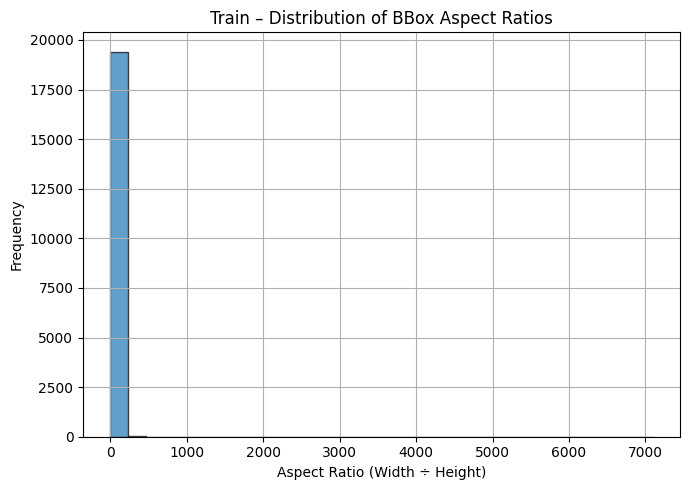

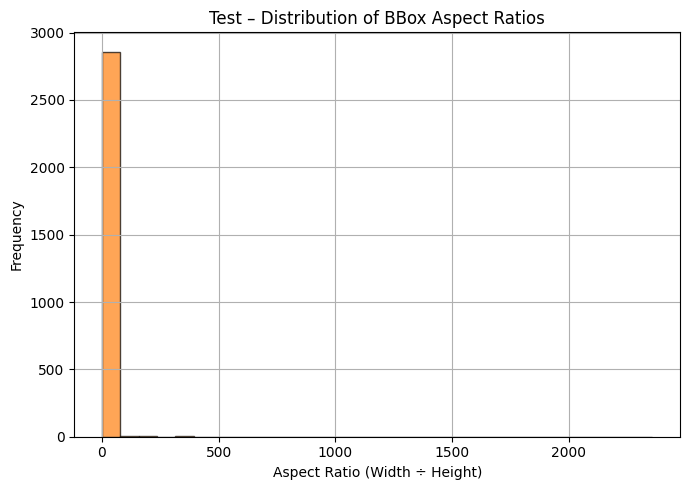

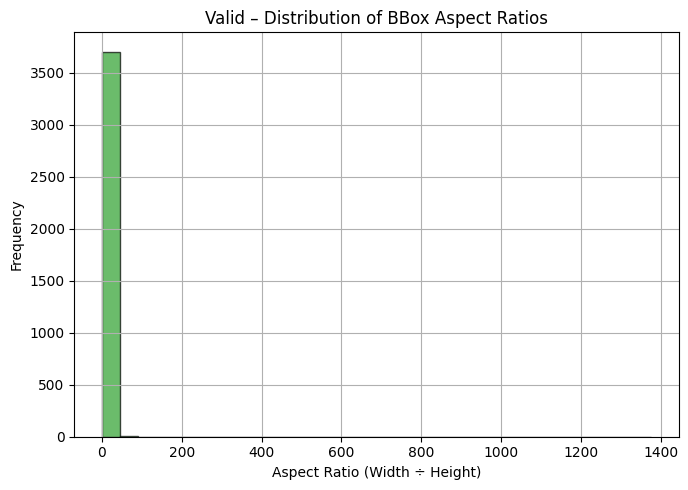

In [ ]:
for split_name, (mw, mh, ma, ar, color) in metrics.items():
    plt.figure(figsize=(7,5))
    plt.hist(ar, bins=30, alpha=0.7, color=color, edgecolor="black")
    plt.title(f"{split_name} – Distribution of BBox Aspect Ratios")
    plt.xlabel("Aspect Ratio (Width ÷ Height)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

and due to the variance of width x height of the bounding boxes, we get varying aspect ratios too

here we also print descriptive statistics for the bounding boxes

### Distribusi Jumlah Bounding Box Per Image

# Preprocessing The Data

now we're going to start prepping our data for training. we're going to resize the images to a standardized width and height, which will reuslt in an aspect ratio of 1:1.

we then will also augment our data by randomly applying transformation to our images

In [ ]:
TARGET_SIZE = (512, 512)
MIN_BOX_PIXELS = 2
MAX_BOXES_PER_IMAGE = 50

train_images = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images"
train_labels = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/train/labels"

test_images  = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/images"
test_labels  = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/labels"

val_images   = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/images"
val_labels   = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/labels"

preproc_base = "/kaggle/input/aerial-ship-dataset/ships-aerial-images/preprocessed"

splits = {
    "train": (train_images, train_labels),
    "test":  (test_images,  test_labels),
    "valid": (val_images,   val_labels)
}

processed_counts = {}
total_kept = 0

for split, (input_img_dir, input_lbl_dir) in splits.items():
    out_img_dir = os.path.join(preproc_base, split, "images")
    out_lbl_dir = os.path.join(preproc_base, split, "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    kept_count = 0

    for lbl_path in glob.glob(os.path.join(input_lbl_dir, "*.txt")):
        base = os.path.basename(lbl_path).rsplit(".", 1)[0]
        img_path = None
        for ext in [".png", ".jpg", ".jpeg", ".bmp"]:
            candidate = os.path.join(input_img_dir, base + ext)
            if os.path.isfile(candidate):
                img_path = candidate
                break
        if img_path is None:
            continue

        with open(lbl_path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]
        if len(lines) > MAX_BOXES_PER_IMAGE:
            continue

        with Image.open(img_path) as img:
            orig_w, orig_h = img.size
            resized = img.resize(TARGET_SIZE)
        scale_x = TARGET_SIZE[0] / orig_w
        scale_y = TARGET_SIZE[1] / orig_h

        new_lines = []
        drop_image = False

        for line in lines:
            parts = line.split()
            if len(parts) < 5:
                drop_image = True
                break
            cls = parts[0]
            x_c_norm = float(parts[1])
            y_c_norm = float(parts[2])
            w_norm   = float(parts[3])
            h_norm   = float(parts[4])

            w_resized = w_norm * orig_w * scale_x
            h_resized = h_norm * orig_h * scale_y
            side_resized = max(w_resized, h_resized)

            if side_resized <= MIN_BOX_PIXELS:
                drop_image = True
                break

            x_c_resized = x_c_norm * TARGET_SIZE[0]
            y_c_resized = y_c_norm * TARGET_SIZE[1]
            x_min = x_c_resized - side_resized / 2
            y_min = y_c_resized - side_resized / 2

            if x_min < 0:
                x_min = 0
            if y_min < 0:
                y_min = 0
            if x_min + side_resized > TARGET_SIZE[0]:
                x_min = TARGET_SIZE[0] - side_resized
            if y_min + side_resized > TARGET_SIZE[1]:
                y_min = TARGET_SIZE[1] - side_resized

            x_c_new = x_min + side_resized / 2
            y_c_new = y_min + side_resized / 2

            new_xc_norm = x_c_new / TARGET_SIZE[0]
            new_yc_norm = y_c_new / TARGET_SIZE[1]
            new_w_norm  = side_resized / TARGET_SIZE[0]
            new_h_norm  = side_resized / TARGET_SIZE[1]

            new_lines.append(f"{cls} {new_xc_norm:.6f} {new_yc_norm:.6f} {new_w_norm:.6f} {new_h_norm:.6f}\n")

        if drop_image:
            continue

        out_img_path = os.path.join(out_img_dir, os.path.basename(img_path))
        resized.save(out_img_path)

        out_lbl_path = os.path.join(out_lbl_dir, os.path.basename(lbl_path))
        with open(out_lbl_path, "w") as fw:
            fw.writelines(new_lines)

        kept_count += 1

    processed_counts[split] = kept_count
    total_kept += kept_count

for split, count in processed_counts.items():
    pct = (count / total_kept * 100) if total_kept else 0
    print(f"{split}: {count} images ({pct:.2f}%)")


train: 0 images (0.00%)
test: 0 images (0.00%)
valid: 0 images (0.00%)


# Building the Model

### Convert to Yolo Format

In [ ]:
import os
import pandas as pd

# Paths
image_folder = "/kaggle/working/aerial-ship-dataset/ships-aerial-images/train/resized_images"
bbox_folder = "/kaggle/working/aerial-ship-dataset/ships-aerial-images/train/resized_labels"
yolo_labels_folder = "/kaggle/working/aerial-ship-dataset/yolo_data/labels/train"
os.makedirs(yolo_labels_folder, exist_ok=True)
os.makedirs(image_folder, exist_ok=True)
os.makedirs(bbox_folder, exist_ok=True)

# Loop through images and convert CSV to YOLO format
for image_name in os.listdir(image_folder):
    if image_name.endswith(".jpg"):
        image_id = image_name.replace('.jpg', '')
        bbox_path = os.path.join(bbox_folder, f"{image_id}_bboxes.csv")

        if os.path.exists(bbox_path):
            bboxes = pd.read_csv(bbox_path)

            # Read image dimensions
            img_path = os.path.join(image_folder, image_name)
            image = cv2.imread(img_path)
            h, w, _ = image.shape

            # Create YOLO format text file
            yolo_path = os.path.join(yolo_labels_folder, f"{image_id}.txt")
            with open(yolo_path, 'w') as f:
                for _, row in bboxes.iterrows():
                    x_min, y_min, x_max, y_max = row[['x_min', 'y_min', 'x_max', 'y_max']]

                    # Convert to YOLO format
                    x_center = ((x_min + x_max) / 2) / w
                    y_center = ((y_min + y_max) / 2) / h
                    width = (x_max - x_min) / w
                    height = (y_max - y_min) / h

                    # Assuming single class (e.g., ship), use class_id = 0
                    f.write(f"0 {x_center} {y_center} {width} {height}\n")
            print(f"Converted {image_name} to YOLO format.")

In [ ]:
import yaml
data_yaml = {
    'path': '/kaggle/input/aerial-ship-dataset/ships-aerial-images',
    'train': 'train/images',
    'val': 'valid/images',
    'names': {0: 'ship'}
}

# Save YAML to file
yaml_path = "/kaggle/working/aerial-ship-dataset/yolo_data/ships_data.yaml"
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file)

print(f"YAML file saved to: {yaml_path}")


YAML file saved to: /kaggle/working/aerial-ship-dataset/yolo_data/ships_data.yaml


### Train Model

after prepping our data, we're going to start training our model. we start with initial epochs of 10 and 4 images per batch. we will be using the yolov8s architecture, a middleground yolo model for both performance and speed

post-training note: initially we tried training the model using the augementerd and resized data found in files resized_images. however an error occured causing the model to not train to completion. hence we opted to use the initial raw dataset (non augmented), but we did still resize through the model.train imgsz parameter)

In [ ]:
model = YOLO('yolo11n.pt')

model.train(
    data='/kaggle/working/aerial-ship-dataset/yolo_data/ships_data.yaml',  # Path to your YAML file
    epochs=10,
    imgsz=512,
    seed=42,
    batch=4,
    workers=4,
    conf=0.25
)

Ultralytics 8.3.151 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.25, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/aerial-ship-dataset/yolo_data/ships_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

train: Scanning /kaggle/input/aerial-ship-dataset/ships-aerial-images/train/labels... 9697 images, 351 backgrounds, 2 corrupt: 100%|██████████| 9697/9697 [00:12<00:00, 801.60it/s]

train: /kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images/1__20180714_180427_1029__-118-20071740708637_33-73029905538088_png.rf.330efa80ecbf49d6ceac7071288d64b4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0249]
train: /kaggle/input/aerial-ship-dataset/ships-aerial-images/train/images/1__20180714_180427_1029__-118-21100741654266_33-732092454738826_png.rf.7243f2b58b505e51950850f4b26081ba.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0079]


WARNING ⚠️ train: Cache directory /kaggle/input/aerial-ship-dataset/ships-aerial-images/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 709, len(boxes) = 19454. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access ✅ (ping: 0.1±0.3 ms, read: 45.4±66.5 MB/s, size: 20.9 KB)


val: Scanning /kaggle/input/aerial-ship-dataset/ships-aerial-images/valid/labels... 2165 images, 68 backgrounds, 0 corrupt: 100%|██████████| 2165/2165 [00:02<00:00, 756.53it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/aerial-ship-dataset/ships-aerial-images/valid is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 172, len(boxes) = 3720. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         1G      1.896       2.69      1.589          2        512: 100%|██████████| 2424/2424 [03:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 20.86it/s]

                   all       2165       3720      0.434      0.213      0.332      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         1G        1.9      1.923      1.588          3        512: 100%|██████████| 2424/2424 [02:47<00:00, 14.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 22.18it/s]

                   all       2165       3720      0.462      0.182      0.312      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.01G      1.802       1.76      1.524          5        512: 100%|██████████| 2424/2424 [02:45<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 21.72it/s]


                   all       2165       3720      0.474      0.213      0.338      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.01G      1.748      1.665      1.483          3        512: 100%|██████████| 2424/2424 [02:44<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 22.00it/s]

                   all       2165       3720      0.627      0.214      0.433      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.01G      1.691      1.575      1.435          3        512: 100%|██████████| 2424/2424 [02:44<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 21.59it/s]

                   all       2165       3720      0.617      0.238      0.445      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.01G      1.604      1.451      1.383          4        512: 100%|██████████| 2424/2424 [02:44<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 21.98it/s]

                   all       2165       3720      0.752       0.23        0.5      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.01G      1.559      1.367      1.358          8        512: 100%|██████████| 2424/2424 [02:43<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 22.18it/s]

                   all       2165       3720      0.694      0.253      0.488      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.01G      1.528      1.338      1.335          4        512: 100%|██████████| 2424/2424 [02:45<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 21.60it/s]

                   all       2165       3720       0.67      0.261      0.488      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.01G      1.484      1.251      1.311          3        512: 100%|██████████| 2424/2424 [02:45<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 21.95it/s]


                   all       2165       3720      0.739      0.259      0.518      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.01G      1.436       1.21      1.266          2        512: 100%|██████████| 2424/2424 [02:47<00:00, 14.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:12<00:00, 22.00it/s]

                   all       2165       3720      0.699      0.268      0.504       0.35



10 epochs completed in 0.500 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.4MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 271/271 [00:10<00:00, 25.48it/s]


                   all       2165       3720      0.739      0.259      0.518      0.352
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c185d655f60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
df

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   194.385         1.89565         2.68974         1.58875   
1      2   374.556         1.89991         1.92251         1.58760   
2      3   552.856         1.80200         1.75960         1.52397   
3      4   730.213         1.74811         1.66510         1.48269   
4      5   907.853         1.69057         1.57516         1.43548   
5      6  1084.910         1.60396         1.45117         1.38272   
6      7  1261.450         1.55885         1.36743         1.35764   
7      8  1439.540         1.52825         1.33849         1.33468   
8      9  1617.750         1.48445         1.25092         1.31065   
9     10  1798.270         1.43591         1.21008         1.26644   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.43421            0.21290           0.33182   
1               0.46206            0.18172           0.31157   
2               0.47394            0.21263           0.33755   
3               0.62707            0.21425           0.43327   
4               0.61715            0.23790           0.44536   
5               0.75220            0.23011           0.49979   
6               0.69389            0.25349           0.48818   
7               0.67034            0.26129           0.48831   
8               0.73890            0.25941           0.51755   
9               0.69895            0.26774           0.50409   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.18330       2.13004       2.32563       1.61391  0.000666   
1              0.16244       2.24187       2.38236       1.70758  0.001201   
2              0.18517       2.23794       2.19160       1.81955  0.001604   
3              0.26156       2.08210       2.01462       1.56369  0.001406   
4              0.27787       1.97339       1.80109       1.49665  0.001208   
5              0.32268       1.93618       1.69258       1.48719  0.001010   
6              0.32181       1.86240       1.65581       1.41770  0.000812   
7              0.32534       1.81405       1.58622       1.40584  0.000614   
8              0.35179       1.83409       1.55835       1.38551  0.000416   
9              0.34999       1.74962       1.51216       1.34962  0.000218   

     lr/pg1    lr/pg2  
0  0.000666  0.000666  
1  0.001201  0.001201  
2  0.001604  0.001604  
3  0.001406  0.001406  
4  0.001208  0.001208  
5  0.001010  0.001010  
6  0.000812  0.000812  
7  0.000614  0.000614  
8  0.000416  0.000416  
9  0.000218  0.000218

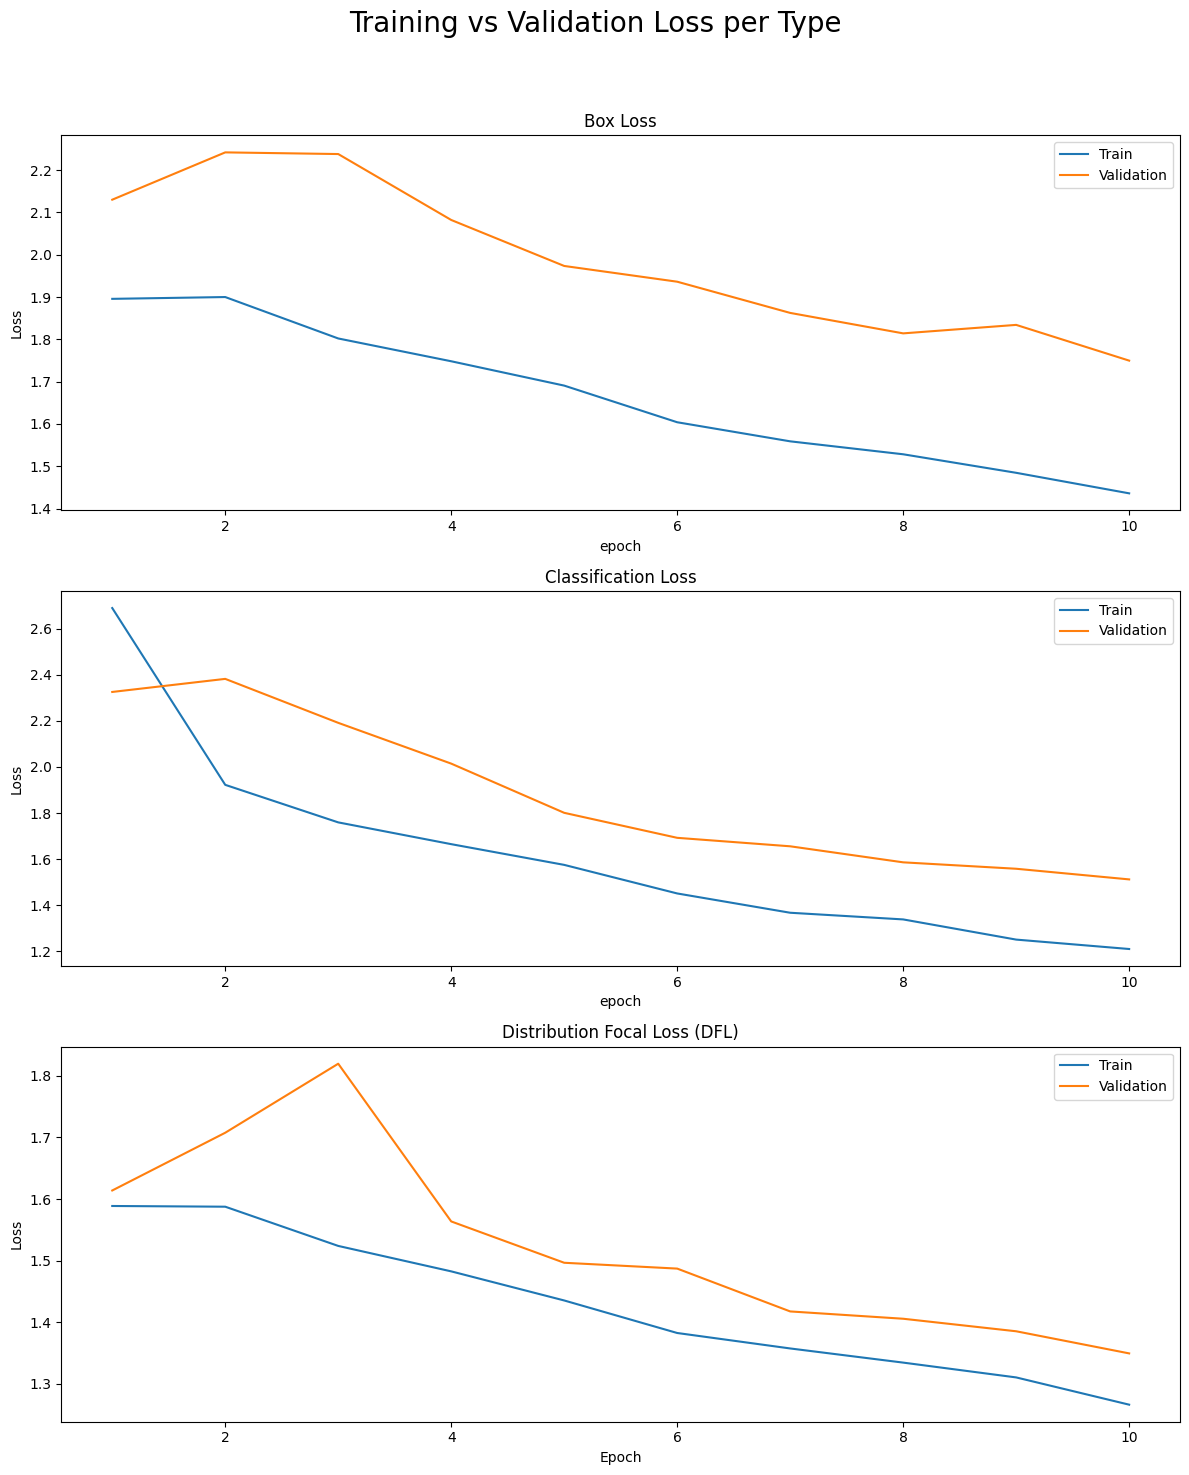


Final Loss Values at Epoch 10
Box Loss - Train: 1.4359, Validation: 1.7496
Classification Loss - Train: 1.2101, Validation: 1.5122
DFL Loss - Train: 1.2664, Validation: 1.3496


In [ ]:
df = pd.read_csv('/kaggle/working/runs/detect/train2/results.csv')
df.columns = df.columns.str.strip()

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# 1. Box Loss
sns.lineplot(x='epoch', y='train/box_loss', data=df, label='Train', ax=axs[0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, label='Validation', ax=axs[0])
axs[0].set_title('Box Loss')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 2. Classification Loss
sns.lineplot(x='epoch', y='train/cls_loss', data=df, label='Train', ax=axs[1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, label='Validation', ax=axs[1])
axs[1].set_title('Classification Loss')
axs[1].set_ylabel('Loss')
axs[1].legend()

# 3. DFL Loss
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, label='Train', ax=axs[2])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, label='Validation', ax=axs[2])
axs[2].set_title('Distribution Focal Loss (DFL)')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()

# Add a common suptitle
plt.suptitle('Training vs Validation Loss per Type', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # make space for suptitle

plt.show()

last_epoch = df['epoch'].max()
final_vals = df[df['epoch'] == last_epoch]

print("\nFinal Loss Values at Epoch", last_epoch)
print(f"Box Loss - Train: {final_vals['train/box_loss'].values[0]:.4f}, Validation: {final_vals['val/box_loss'].values[0]:.4f}")
print(f"Classification Loss - Train: {final_vals['train/cls_loss'].values[0]:.4f}, Validation: {final_vals['val/cls_loss'].values[0]:.4f}")
print(f"DFL Loss - Train: {final_vals['train/dfl_loss'].values[0]:.4f}, Validation: {final_vals['val/dfl_loss'].values[0]:.4f}")


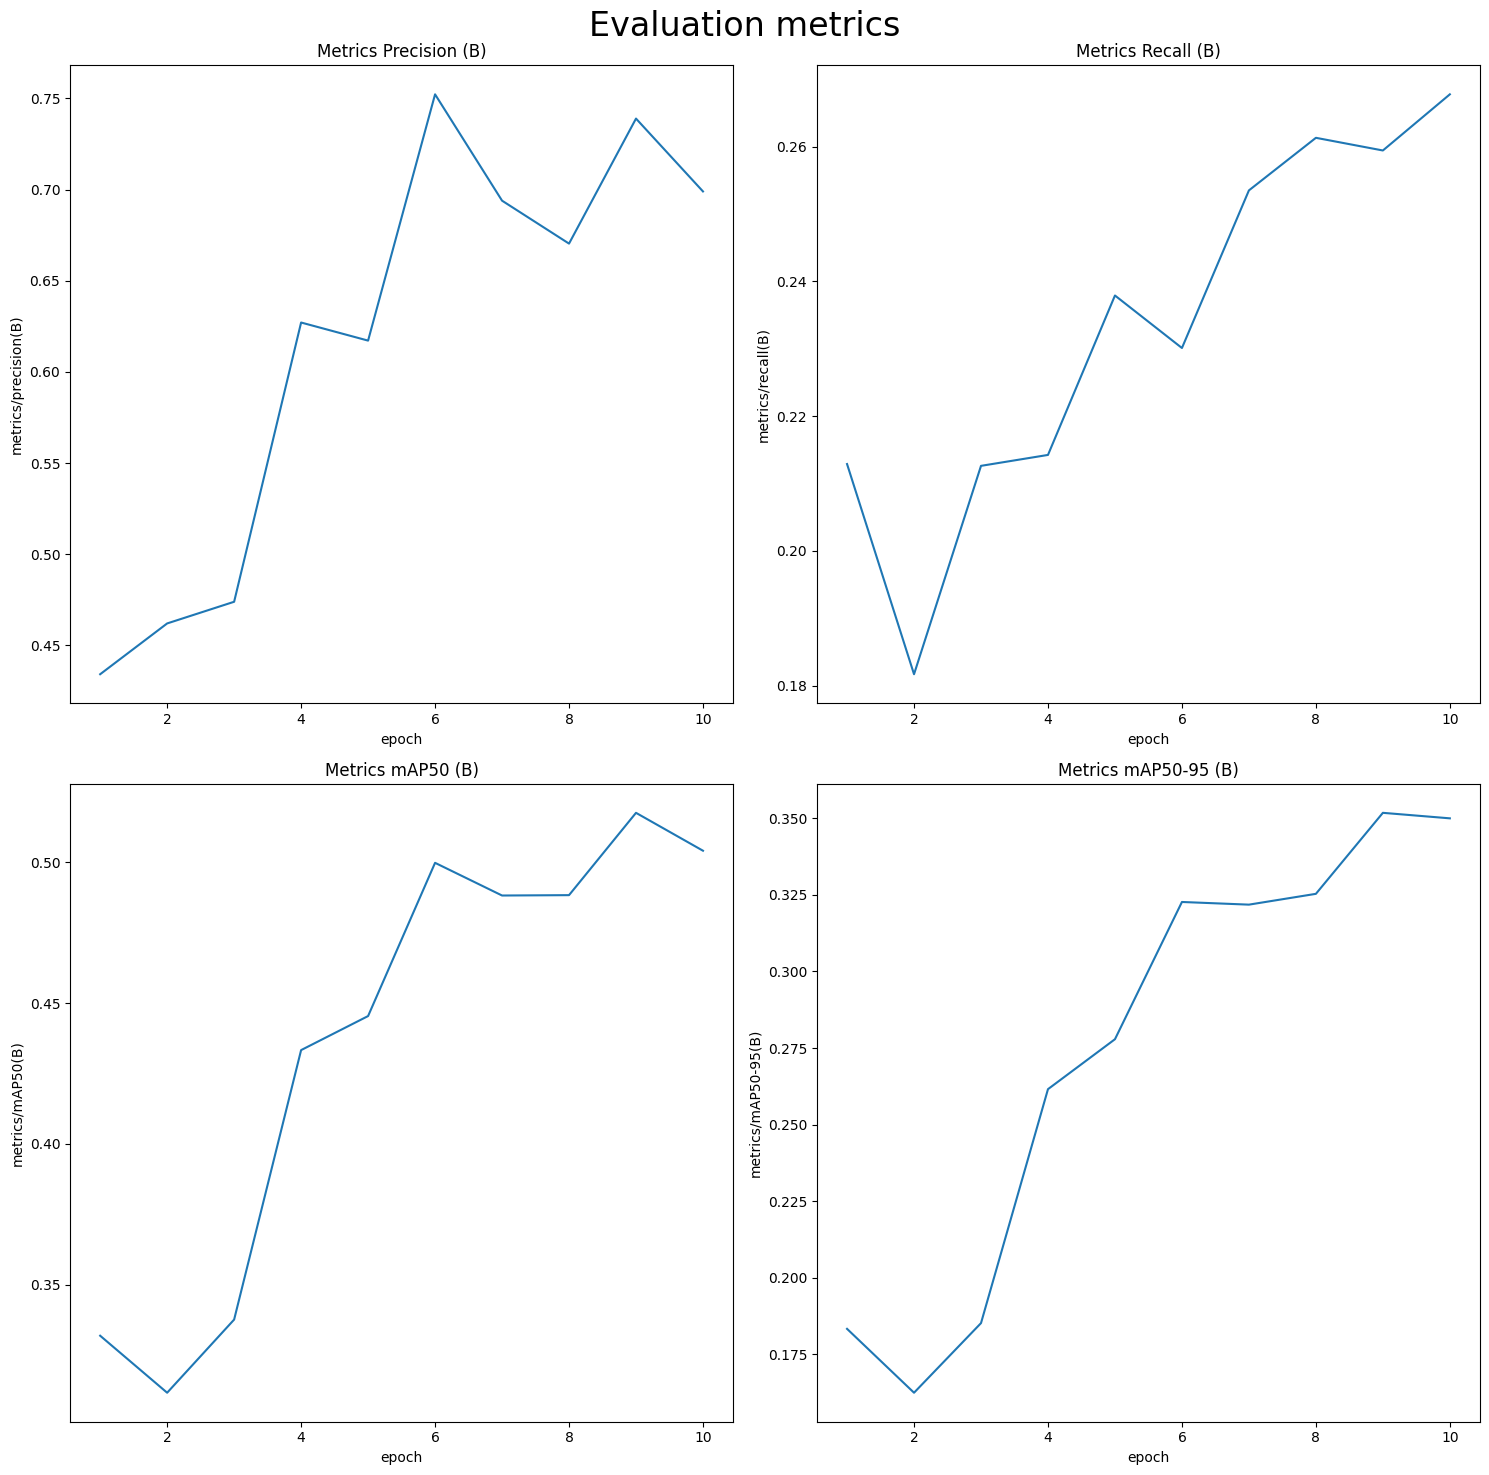

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))


sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[1,1])

axs[0,0].set(title='Metrics Precision (B)')
axs[0,1].set(title='Metrics Recall (B)')
axs[1,0].set(title='Metrics mAP50 (B)')
axs[1,1].set(title='Metrics mAP50-95 (B)')

# add suptitle and subheader
plt.suptitle('Evaluation metrics', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()


from the loss curves of both train and val, we can see that they both decrease over epochs. however the graphs havent plateued, meaning there could potentially be improvements if we were to increase the epochs for training in the future

for the 4 scoring metrics we used, recall, prec, map50 and map50:95. all metrics increased over epochs. however similar to the loss graphs, we think training over longer epochs may yield better results

# Testing

In [ ]:
def ship_detect(img_path):

    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()

    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 512x512 (no detections), 8.2ms
Speed: 4.3ms preprocess, 8.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 7.7ms
Speed: 1.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 9.3ms
Speed: 1.5ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.2ms
Speed: 1.5ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 1 ship, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 51

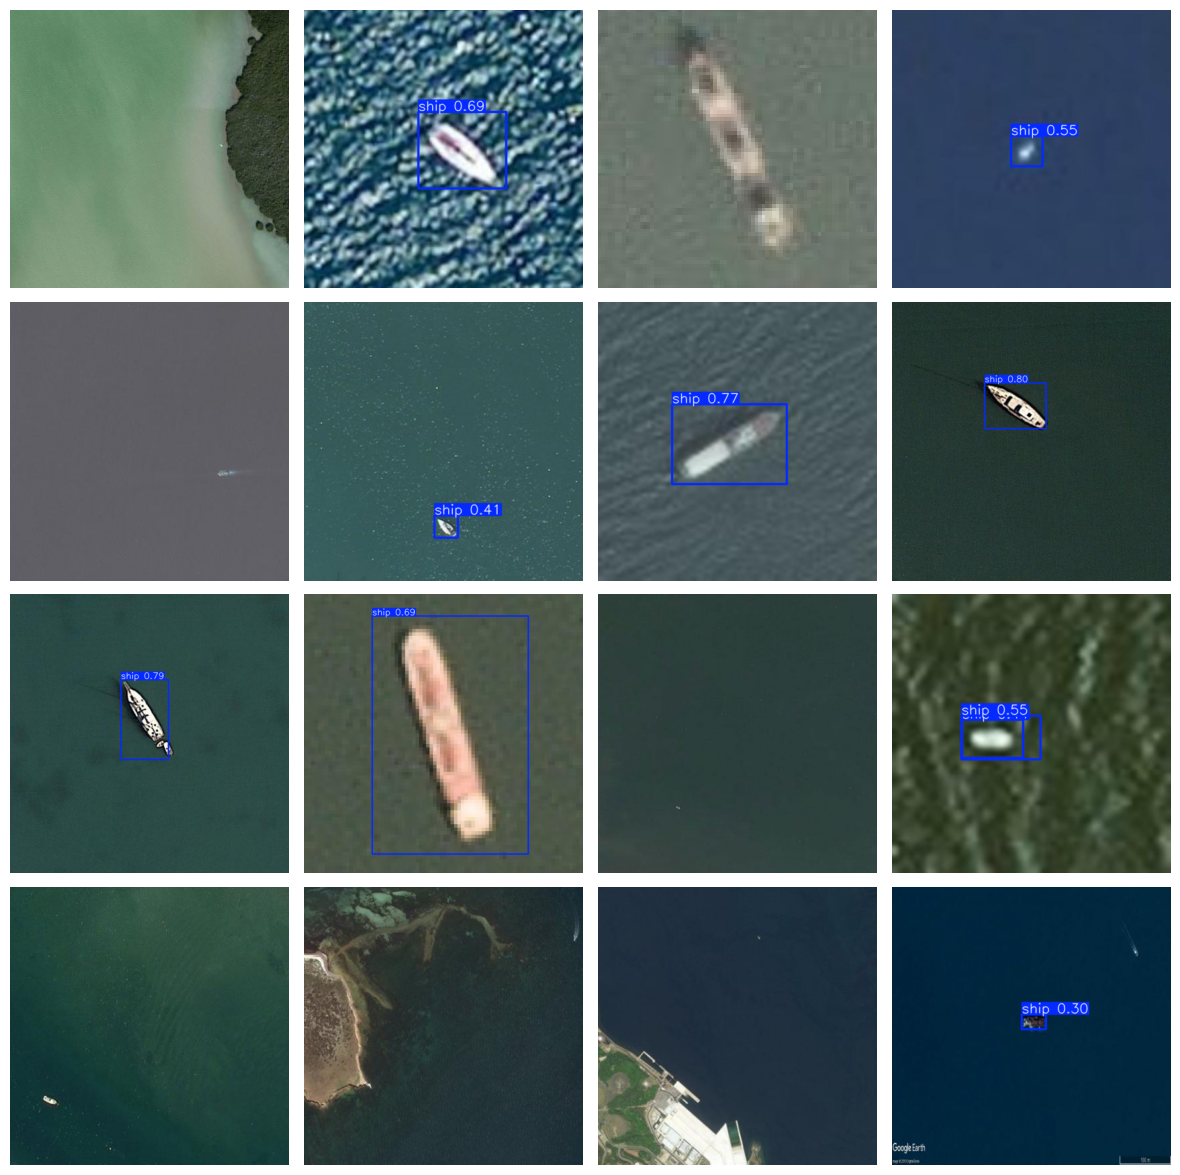

In [ ]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/aerial-ship-dataset/ships-aerial-images/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):

    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = ship_detect(img_path)

    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

from the randomly samples images, we can see that our model performs decently well. its able to detect ships where they contrast with the background. however in cases where the ships may seem blurry, small or  blend in rather well with the background, our model fails to detect the ships

# Existing challenges and future oppurtunities

one of the biggest problem was an error during augementing our data, which prevented our model from training using the augmented images, and instead we used raw images. in the future, we'll try to fix the augmentation section of our data to allow our model to train with it

some other future oppurtunities we can seize is one, the parameters of training. from the results of the training, we cna see that the graphs havent fully plateued yet, meaning that there were insuffiencet epochs for convergence. in the future we could train the model over longer epochs to potentially yield better results

in our current iteration, we used the yolov8s model, which is one of the smaller yolo architecture. in the future we'll try to use more complex architectures such as yolov8x or yolov8l. hoping to improve the detecting ability of our model